In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1
Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного спуска и стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.

In [2]:
from sklearn import datasets

X_, y_, coef = datasets.make_regression(n_samples=1000, 
                                      n_features=2, 
                                      n_informative=2, 
                                      n_targets=1,
                                      noise=5, 
                                      coef=True, 
                                      random_state=42)

In [3]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [4]:
X_ = np.c_[ np.ones(1000) , X_]  # Добавим столбик с единицами

In [5]:
w = np.linalg.inv(X_.T @ X_) @ X_.T @ y_

In [6]:
calc_mse(y_, np.dot(X_, w)) # Эталонное решение

24.213592803209053

In [7]:
def gradient_descent(X, y, iterations, eta = 1e-2):  
    
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]


    for i in range(iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (np.dot(X, w) - y)))
         
    return err

In [8]:
def eval_SGD(X, y, iterations, eta=1e-4):
    
    np.random.seed(42)
    w = np.random.randn(X.shape[1]) # начальное приближение весов
    n = X.shape[0] # число наблюдений
    
    for i in range(1, iterations + 1):
        err = calc_mse(y, np.dot(X, w))
        # генерируем случайный индекс объекта выборки
        ind = np.random.randint(n)
        y_pred = np.dot(X[ind], w)
        w -= eta * (2 * np.dot(X[ind].T, (y_pred - y[ind])))
#         if i % (iterations / 10) == 0:
#             print(f'{i}: weights={w}, MSE={err:.3f}')
    return err

In [9]:
def eval_mbGD(X, y, iterations, batch=100, eta=1e-4):
    
    np.random.seed(42)
    w = np.random.randn(X.shape[1]) # начальное приближение весов
    n = X.shape[0] # число наблюдений
    n_batch = n // batch # число батчей
    
    if n % batch != 0:
        n_batch += 1
#     print('Количество батчей - ', n_batch)
    for i in range(1, iterations + 1):
        err = calc_mse(y, np.dot(X, w))
        for b in range(n_batch):
            start_ = batch * b
            end_ = batch * (b + 1)
            X_batch = X[start_ : end_, :]
            y_batch = y[start_ : end_]
            y_pred = np.dot(X_batch, w)
            w -= eta * (2/len(y_batch) * np.dot(X_batch.T, (y_pred - y_batch)))
#         if i % (iterations / 10) == 0:
#             print(f'{i}: weights={w}, MSE={err:.3f}')
    return err

In [10]:
gd_mse_list = []         # Список из ошибок MSE для град. спуска
gd_iterations_list = []  # Список количества итераций для град. спуска

for i in range(1, 2001, 200):   # Задаем количество итераций
    gd_iterations_list.append(i)
    gd_mse_list.append(gradient_descent(X_, y_, i))
    
eval_SGD_mse_list = []
eval_SGD_iterations_list = []

for i in range(1, 3100, 200):
    eval_SGD_iterations_list.append(i)
    eval_SGD_mse_list.append(eval_SGD(X_, y_, i))
    
eval_mbGD_mse_list = []
eval_mbGD_iterations_list = []

for i in range(1, 2200, 300):
    eval_mbGD_iterations_list.append(i)
    eval_mbGD_mse_list.append(eval_mbGD(X_, y_, i))

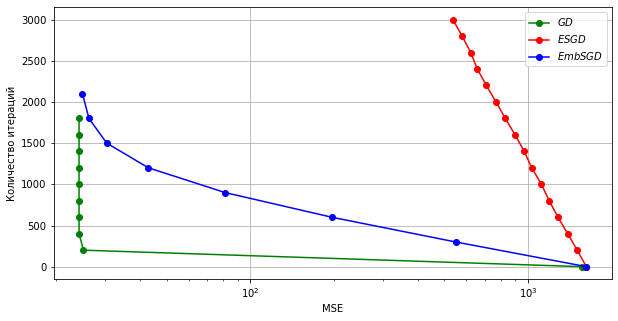

In [11]:
plt.figure(figsize=(10, 5))
plt.xscale('log')

plt.plot(gd_mse_list, gd_iterations_list, 'go-', label=r'$GD$')
plt.plot(eval_SGD_mse_list, eval_SGD_iterations_list, 'ro-', label=r'$ESGD$')
plt.plot(eval_mbGD_mse_list, eval_mbGD_iterations_list, 'bo-', label=r'$EmbSGD$')
plt.xlabel('MSE')
plt.ylabel('Количество итераций')
plt.grid()
plt.legend();

Исходя из графика видно, что самым оптимальным способом является обычный градиентный спуск, ему нужно наименьшее количество итераций для минимизации MSE. Следующий метод - метод mini-batch, однако количество итераций в нем больше, чем в остальных методах, так как внутри итерации есть еще итерации по каждому батчу. Больше всего итераций нужно методу стохастического градиентного спуска 

## 2
[*] Добавить в алгоритм градиентного спуска L1 регуляризацию. Сравнить влияние коэффициентов регуляризации L1 и L2 на величину весов для примера из урока (лучше графически).

$$\sum^{n}_{i=1}L_i(\vec{x}_i,{y_i},\vec{w}) + \lambda \sum^{m}_{j=1}|w_{j}| \rightarrow \underset{w}{\text{min}}$$

$$\sum^{n}_{i=1}L_i(\vec{x}_i,y_i,\vec{w}) + \lambda \sum^{m}_{j=1}w_{j}^{2} \rightarrow \underset{w}{\text{min}}$$

In [12]:
def eval_model_reg1(X, y, iterations, eta=1e-4, lambda_=1e-8, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + lambda_ * np.sign(w))   # Отличие от L2 как в уроке тут 
                                                                                  # (...+ lambda_ * np.sign(w))
    return w

In [13]:
def eval_model_reg2(X, y, iterations, eta=1e-4, lambda_=1e-8, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + 2 * lambda_ * w)

    return w

In [14]:
r1_w_list = []
r1_lambda_list = []

for l in np.logspace(start=-4, stop=1, num=20):
    r1_lambda_list.append(l)
    r1_w_list.append(eval_model_reg1(X_, y_, iterations=1000, eta=0.003, lambda_=l, verbose=True))

r1lambda = np.array(r1_lambda_list)    
r1weights = np.array(r1_w_list)

In [15]:
r2_w_list = []
r2_lambda_list = []

for l in np.logspace(start=-4, stop=1, num=20):
    r2_lambda_list.append(l)
    r2_w_list.append(eval_model_reg2(X_, y_, iterations=1000, eta=0.003, lambda_=l, verbose=True))

r2lambda = np.array(r2_lambda_list)    
r2weights = np.array(r2_w_list)

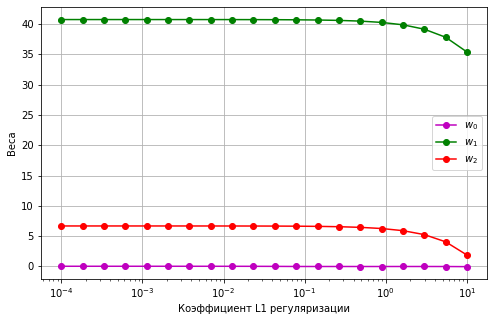

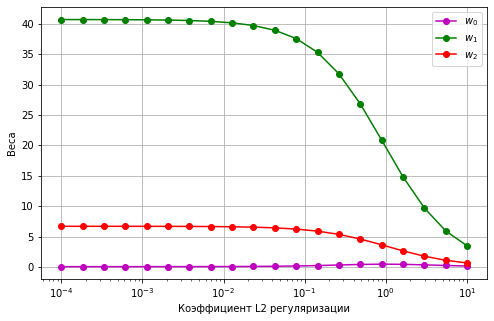

In [16]:
plt.figure(figsize=(8, 5))
plt.xscale('log')
plt.plot(r1lambda, r1weights[:, 0], 'mo-', label=r'$w_0$')
plt.plot(r1lambda, r1weights[:, 1], 'go-', label=r'$w_1$')
plt.plot(r1lambda, r1weights[:, 2], 'ro-', label=r'$w_2$')
plt.xlabel('Коэффициент L1 регуляризации')
plt.ylabel('Веса')
plt.grid()
plt.legend();

plt.figure(figsize=(8, 5))
plt.xscale('log')
plt.plot(r2lambda, r2weights[:, 0], 'mo-', label=r'$w_0$')
plt.plot(r2lambda, r2weights[:, 1], 'go-', label=r'$w_1$')
plt.plot(r2lambda, r2weights[:, 2], 'ro-', label=r'$w_2$')
plt.xlabel('Коэффициент L2 регуляризации')
plt.ylabel('Веса')
plt.grid()
plt.legend();